# Loop Workflow Example 3

* High level approach to making a 3D model from just a bounding box and source files as input. (In Australia only for now. Documentation to come)
* This notebook uses example data provided by the Geological Survey of Western Australia.
* To run with your own data you will need to run the Utility 1 notebook to create an hjson config file and supply your own dtm model (service or geotif file in local coordinate system)

In [1]:
#if not already installed:
#!conda install -c loop3d map2loop loopstructural pyamg meshio

#FOR UPCOMING CHANGES IN MAP2LOOP AND LPF branches fix_thicknesses

## Map2Loop

In [2]:
from map2loop.project import Project
from map2loop.m2l_enums import VerboseLevel
from map2loop.m2l_enums import Datatype
from map2loop.sampler import SamplerSpacing, SamplerDecimator
from map2loop.sorter import SorterUseHint, SorterUseNetworkX, SorterAgeBased, SorterAlpha

import os

# Specify the boundary of the region of interest in the appropriate projection coordinates
bounding_box = {
    "minx": 520000,
    "miny": 7490000,
    "maxx": 550000,
    "maxy": 7510000,
    "base": -3200,
    "top": 1200,
}

# define the name of the LoopProjectFile to be created
loop_project_filename = os.path.join( "local_source.loop3d")

# define the configuration dictionary to be used by map2loop (this replaces the legacy .hjson file)
config_dictionary = {
  "structure" : {
    "dipdir_column": "azimuth2",
    "dip_column": "dip",},
  "geology" : {
    "unitname_column": "unitname",
    "alt_unitname_column": "code"}, 
  "fault": {
      "minimum_fault_length": 0}
}


# Initialise the project with the shapefiles, dtm, config file
# output locations and projection to work in
proj = Project( 
    geology_filename = "./source_data/geol_clip_no_gaps.shp", # required
    fault_filename = "./source_data/faults_clip.shp", # optional
    structure_filename = "./source_data/structure_clip.shp", #required
    dtm_filename = './source_data/dtm_rp.tif', # required, 
    config_dictionary = config_dictionary,
    clut_filename = './source_data/500kibg_colours.csv', # optional: if this file is not provided, random colours will be used in map2loop
    verbose_level = VerboseLevel.NONE,
    working_projection = "EPSG:28350",
    bounding_box = bounding_box,
    loop_project_filename = loop_project_filename,
    overwrite_loopprojectfile = True, 
)

# Remove faults less than 5km
proj.set_minimum_fault_length(5000.0) # this updates the value set on the config_dictionary

# Set sampling distance for geology and fault maps to 200m
proj.set_sampler(Datatype.GEOLOGY, SamplerSpacing(200.0))
proj.set_sampler(Datatype.FAULT, SamplerSpacing(200.0))

# Set to only take every second orientation observation (0 or 1 means take all observations)
proj.set_sampler(Datatype.STRUCTURE, SamplerDecimator(2))

# Set what text is expected for intrusions (contained within the description field)
proj.map_data.config.geology_config["intrusive_text"] = "mafic intrusive"

# Set specific layers from the geology map to be ignored (commonly "cover" or "water")
proj.set_ignore_lithology_codes(["cover", "Fortescue_Group", "A_FO_od"])

# Set a fault to be ignored (by name)
# proj.set_ignore_codes(["Fault_9"])

# Specify which stratigraphic columns sorter to use, other options are
# (SorterAlpha, SorterAgeBased, SorterUseHint, SorterUseNetworkX, SorterMaximiseContacts, SorterObservationProjections)
# proj.set_sorter(SorterAlpha())

# Or you can run map2loop and pre-specify the stratigraphic column
column = [
    # youngest
    'Turee_Creek_Group',
    'Boolgeeda_Iron_Formation',
    'Woongarra_Rhyolite',
    'Weeli_Wolli_Formation',
    'Brockman_Iron_Formation',
    'Mount_McRae_Shale_and_Mount_Sylvia_Formation',
    'Wittenoom_Formation',
    'Marra_Mamba_Iron_Formation',
    'Jeerinah_Formation',
    'Bunjinah_Formation',
    'Pyradie_Formation',
    'Fortescue_Group',
    # oldest
]
proj.run_all(user_defined_stratigraphic_column=column)

# Or you can get map2loop to run all column sorting algorithms it has and takes the one
# that has the longest total basal contact length
# proj.run_all(take_best=True)

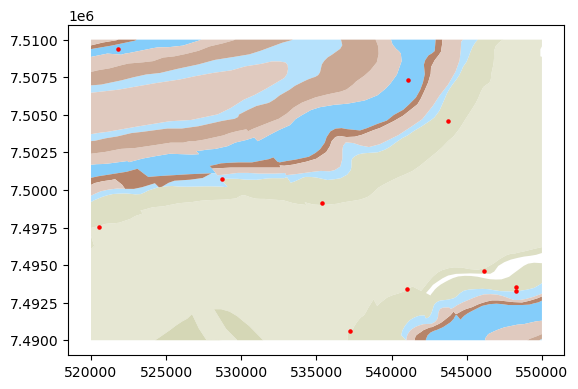

In [3]:
# Draw overlay of point data on geology map
# (options are 'basal_contacts', contacts','orientations','faults')
proj.draw_geology_map(overlay="orientations")

In [4]:
# Extract estimate of the stratigraphic column
proj.stratigraphic_column.column

['Turee_Creek_Group',
 'Boolgeeda_Iron_Formation',
 'Woongarra_Rhyolite',
 'Weeli_Wolli_Formation',
 'Brockman_Iron_Formation',
 'Mount_McRae_Shale_and_Mount_Sylvia_Formation',
 'Wittenoom_Formation',
 'Marra_Mamba_Iron_Formation',
 'Jeerinah_Formation',
 'Bunjinah_Formation',
 'Pyradie_Formation',
 'Fortescue_Group']

In [5]:
proj.stratigraphic_column.stratigraphicUnits

,layerId,name,minAge,maxAge,group,supergroup,stratigraphic_Order,InterpolatedStructure_mean,InterpolatedStructure_median,InterpolatedStructure_stddev,code,colour
0,7,Turee_Creek_Group,0.0,100000.0,,,0,-1.000000,-1.000000,-1.000000,P__TK_s,#E0CABF
1,0,Boolgeeda_Iron_Formation,0.0,100000.0,,,1,509.556595,513.354858,135.743076,P__HAo_ci,#B5E1FC
2,10,Woongarra_Rhyolite,0.0,100000.0,,,2,820.858893,662.296336,404.945806,P__HAw_fr,#CAA894
3,8,Weeli_Wolli_Formation,0.0,100000.0,,,3,549.662204,488.062782,182.004814,P__HAj_xci_od,#E0CABF
4,1,Brockman_Iron_Formation,0.0,100000.0,,,4,990.994292,903.475068,476.312269,P__HAb_cib,#84CDFA
5,5,Mount_McRae_Shale_and_Mount_Sylvia_Formation,0.0,100000.0,,,5,573.961909,307.556407,479.962615,A_HAu_xsl_ci,#B6846A
6,9,Wittenoom_Formation,0.0,100000.0,,,6,703.322105,401.896645,1022.102378,A_HAd_kd,#E0CABF
7,4,Marra_Mamba_Iron_Formation,0.0,100000.0,,,7,300.352122,286.260980,123.595567,A_HAm_cib,#B5E1FC
8,3,Jeerinah_Formation,0.0,100000.0,,,8,862.059373,802.826060,364.730147,A_FOj_xs_b,#DDDFC4
9,2,Bunjinah_Formation,0.0,100000.0,,,9,5956.337377,5811.528686,2698.180621,A_FOu_bbo,#E6E7D3


## Loop Structural

In [6]:
import LoopProjectFile as LPF
import LoopStructural
from LoopStructural.modelling.input.project_file import LoopProjectfileProcessor as LPFProcessor
from LoopStructural.visualisation import Loop3DView
import numpy as np

# LoopStructural Modelling
fault_params = {
    'interpolatortype':'FDI',
    'nelements':1e4,
}
foliation_params = {
    'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
    'nelements':1e5,  # how many tetras/voxels
    'regularisation':5,
}
projFile = LPF.ProjectFile(loop_project_filename)
processedData = LPFProcessor(projFile)

In [7]:
processedData.thicknesses['Pyradie_Formation'] = 600
processedData.thicknesses

{'Turee_Creek_Group': inf,
 'Boolgeeda_Iron_Formation': 513.3548578608784,
 'Woongarra_Rhyolite': 662.2963361473105,
 'Weeli_Wolli_Formation': 488.06278213390567,
 'Brockman_Iron_Formation': 903.475067985537,
 'Mount_McRae_Shale_and_Mount_Sylvia_Formation': 307.55640655664024,
 'Wittenoom_Formation': 401.8966449836911,
 'Marra_Mamba_Iron_Formation': 286.2609804336047,
 'Jeerinah_Formation': 802.8260596759528,
 'Bunjinah_Formation': 5811.5286857790325,
 'Pyradie_Formation': 600}

In [8]:
processedData.foliation_properties['sg'] = foliation_params
processedData.fault_properties['interpolatortype'] = fault_params['interpolatortype']
processedData.fault_properties['nelements'] = fault_params['nelements']

model = LoopStructural.GeologicalModel.from_processor(processedData)
model.nsteps=np.array([100,100,50])
model.update()

                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal
                    Defaulting to a dip of 90vertical fault
                          projected onto fault surface estimating from fault normal


  0%|          | 0/19 [00:00<?, ?it/s]

In [9]:
view = Loop3DView(model)
view.plot_model_surfaces()
view.display()

Widget(value='<iframe src="http://localhost:62369/index.html?ui=P_0x2a1163cb690_0&reconnect=auto" class="pyvis…